In [ ]:
#Model architecture inspired by Y. Kim, "Convolutional Neural Networks for Sentence Classification", 2014
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import re
import nltk
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Flatten
from keras.layers.embeddings import Embedding

In [ ]:
# Get glove.6B.300d.txt beforehand

embeddings_index = {}
with open("LOCAL_PATH_TO_glove.6B.300d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
df = pd.read_csv('LOCAL_PATH_TO_DATASET')
df = df[['Emotion','Statement']]
display(df.head())

,Emotion,Statement
0,guilt,Once when I was in the cell group (religious a...
1,shame,When I overslept for the second time on the da...
2,shame,I had not punched a ticket in the bus because ...
3,disgust,When a man spoke very sexistly in the company ...
4,shame,About a dozen girls laughed at me and I was su...


In [ ]:
def process_text(document):
     
    # Remove extra white space from text
    document = re.sub(r'\s+', ' ', document, flags=re.I)
         
    # Remove all the special characters from text
    document = re.sub(r'\W', ' ', str(document))
 
    # Remove all single characters from text
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
 
    # Converting to Lowercase
    document = document.lower()
 
    # Word tokenization       
    tokens = document.split()

    tokens = [token for token in tokens if token not in en_stop]
                 
    clean_txt = ' '.join(tokens)
 
    return clean_txt

In [ ]:
from tqdm import tqdm

nltk.download('stopwords')
# For sentence tokenization
#nltk.download('punkt')
en_stop = set(nltk.corpus.stopwords.words('english'))

nltk.download('wordnet')
df['preprocessedStatement'] = df.Statement.apply(process_text)
display(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,Emotion,Statement,preprocessedStatement
0,guilt,Once when I was in the cell group (religious a...,cell group religious activity found almost eve...
1,shame,When I overslept for the second time on the da...,overslept second time day examination
2,shame,I had not punched a ticket in the bus because ...,punched ticket bus card ticket collector came ...
3,disgust,When a man spoke very sexistly in the company ...,man spoke sexistly company friends mine
4,shame,About a dozen girls laughed at me and I was su...,dozen girls laughed sure nothing wrong


In [ ]:
max_length = df.preprocessedStatement.apply(lambda x: len(x.split())).max()

t = Tokenizer()
t.fit_on_texts(df['preprocessedStatement'] )
vocab_size = len(t.word_index) + 1
encoded_text = t.texts_to_sequences(df['preprocessedStatement'] )
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
import tensorflow as tf

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# Encode labels in column 'Emotion'. 
df['Emotion'] = le.fit_transform(df['Emotion']) 
y = df.pop('Emotion')
y_new = tf.keras.utils.to_categorical(y, num_classes=7)
print(y_new)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y_new, test_size=0.05, stratify=y_new)

x_val = x_train[:100]
y_val = y_train[:100]
x_train = x_train[100:]
y_train = y_train[100:]

In [ ]:
from tensorflow.keras import activations

def focal_loss(gamma=2., alpha=4., from_logits=False):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax if from_logits is False.
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        if from_logits:
            y_pred = activations.softmax(y_pred)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed


In [ ]:
list(le.inverse_transform([0,1,2,3,4,5,6]))

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [ ]:
y.value_counts()

4    1092
5    1082
0    1079
2    1076
6    1071
1    1066
3    1050
Name: Emotion, dtype: int64

In [ ]:
# 2 options to handle imbalanced dataset: class_weight or focal loss
class_weight = {0: 6, 1: 22, 2: 30, 3: 1, 4: 2, 5: 7, 6: 5}

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=3)
model_glove = Sequential()
model_glove.add(Embedding(vocab_size, 300, input_length=max_length, weights=[embedding_matrix], trainable=False))
model_glove.add(Conv1D(128, 5, activation='relu'))
model_glove.add(GlobalMaxPooling1D())
model_glove.add(Flatten())
model_glove.add(Dense(64, activation='relu'))
model_glove.add(Dense(7, activation='softmax'))
#model_glove.compile(loss=focal_loss(alpha=1), optimizer='adam', metrics=['accuracy']) #use if you are using focal loss
model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #use if you are using class_weight
model_glove.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 78, 300)           2651700   
_________________________________________________________________
conv1d (Conv1D)              (None, 74, 128)           192128    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 455       
Total params: 2,852,539
Trainable params: 200,839
Non-trainable params: 2,651,700
_________________________________________________________________


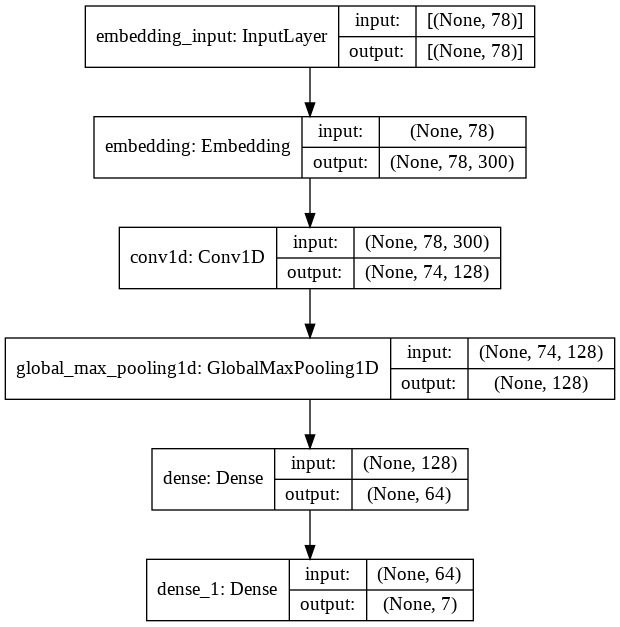

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_glove,show_shapes= True)

In [ ]:
model_glove.fit(x_train, y_train, epochs = 20, validation_data=(x_val, y_val), callbacks=[callback]) #insert class_weight=class_weight if using class_weight

Epoch 1/20
220/220 [==============================] - 3s 7ms/step - loss: 1.4652 - accuracy: 0.4564 - val_loss: 1.3217 - val_accuracy: 0.5300
Epoch 2/20
220/220 [==============================] - 1s 6ms/step - loss: 0.9194 - accuracy: 0.6814 - val_loss: 1.2101 - val_accuracy: 0.5600
Epoch 3/20
220/220 [==============================] - 1s 6ms/step - loss: 0.5682 - accuracy: 0.8213 - val_loss: 1.4469 - val_accuracy: 0.5500
Epoch 4/20
220/220 [==============================] - 1s 6ms/step - loss: 0.2972 - accuracy: 0.9180 - val_loss: 1.5031 - val_accuracy: 0.5700
Epoch 5/20
220/220 [==============================] - 1s 6ms/step - loss: 0.1443 - accuracy: 0.9665 - val_loss: 1.6007 - val_accuracy: 0.5900
Epoch 6/20
220/220 [==============================] - 1s 6ms/step - loss: 0.0764 - accuracy: 0.9847 - val_loss: 1.9355 - val_accuracy: 0.5400
Epoch 7/20
220/220 [==============================] - 1s 6ms/step - loss: 0.0517 - accuracy: 0.9889 - val_loss: 2.0402 - val_accuracy: 0.5600
Epoch 

In [ ]:
y_pred = model_glove.predict(x_test)

In [ ]:
y_pred_clean = np.argmax(y_pred, 1)
y_test_clean = np.argmax(y_test, 1)

In [ ]:
print(classification_report(y_test_clean, y_pred_clean))

              precision    recall  f1-score   support

           0       0.52      0.57      0.54        54
           1       0.43      0.47      0.45        53
           2       0.67      0.57      0.62        54
           3       0.59      0.33      0.42        52
           4       0.52      0.75      0.61        55
           5       0.57      0.56      0.56        54
           6       0.49      0.46      0.48        54

    accuracy                           0.53       376
   macro avg       0.54      0.53      0.53       376
weighted avg       0.54      0.53      0.53       376

